In [39]:
# This notebook handles all data cleaning, validation, and preprocessing steps for the Indian agricultural dataset.

#1. Import libraries and setup 

import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import missingno as msno
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats 
import pickle 
import os 



#Set Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print(f"Analysis started at : {datetime.now()}")



Analysis started at : 2025-12-02 16:52:23.002749


In [40]:
#2. Load and Inspect Raw Data 

df =  pd.read_csv('../data/Crops_data.csv')

print(f"Dataset Shape:  {df.shape}")
print(f"Columns:  {len(df.columns)}")
print(f"Years Covered: {df['Year'].unique()}")
print(f"States covered: {df['State Name'].unique()}")
print(f"Number of districts:  {df['Dist Name'].nunique()}")

# Display basic information 

print("Dataset Information:")
print("=" * 80 )
print(df.info())


# Check for Duplicates 
print(f"\nDuplicated rows: {df.duplicated().sum()}")


Dataset Shape:  (2484, 80)
Columns:  80
Years Covered: [2010 2011 2012 2013 2014 2015 2016 2017]
States covered: ['Chhattisgarh' 'Madhya Pradesh' 'Andhra Pradesh' 'Telangana' 'Karnataka'
 'Tamil Nadu' 'Maharashtra' 'Gujarat' 'Rajasthan' 'Punjab' 'Haryana'
 'Uttar Pradesh' 'Uttarakhand' 'Assam' 'Himachal Pradesh' 'Kerala'
 'Orissa' 'West Bengal' 'Bihar' 'Jharkhand']
Number of districts:  311
Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 80 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Dist Code                                    2484 non-null   int64  
 1   Year                                         2484 non-null   int64  
 2   State Code                                   2484 non-null   int64  
 3   State Name                                   2484 non-null   object 
 4   Dist Name                    


Data Quality Report:
                                   Column Data_Type  Null_Percentage  \
0                               Dist Code     int64              0.0   
1                                    Year     int64              0.0   
2                              State Code     int64              0.0   
3                              State Name    object              0.0   
4                               Dist Name    object              0.0   
5                     RICE AREA (1000 ha)   float64              0.0   
6             RICE PRODUCTION (1000 tons)   float64              0.0   
7                  RICE YIELD (Kg per ha)   float64              0.0   
8                    WHEAT AREA (1000 ha)   float64              0.0   
9            WHEAT PRODUCTION (1000 tons)   float64              0.0   
10                WHEAT YIELD (Kg per ha)   float64              0.0   
11          KHARIF SORGHUM AREA (1000 ha)   float64              0.0   
12  KHARIF SORGHUM PRODUCTION (1000 tons) 

<Figure size 1600x800 with 0 Axes>

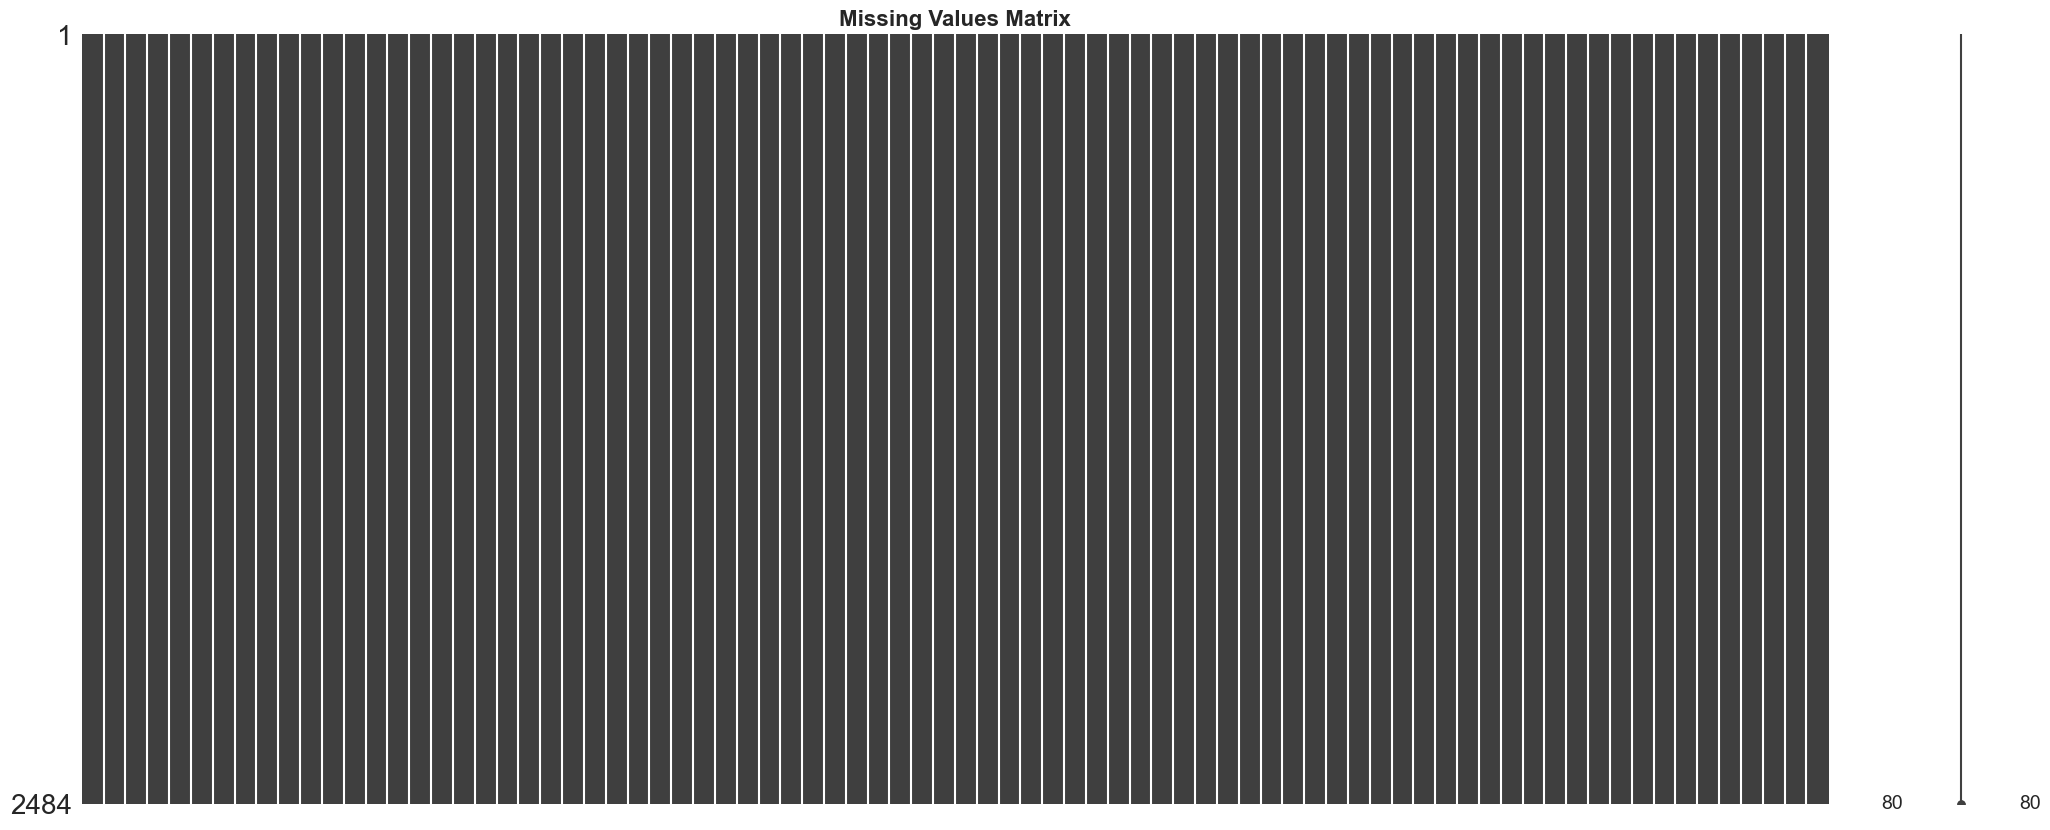

In [41]:
#  3 Data Quality Assessment 

def assess_data_quality(df):
    """Comprehensive data quality assessment"""
    
    quality_report = pd.DataFrame({
        'Column': df.columns,
        'Data_Type': df.dtypes.values,
        'Non_Null_Count': df.count().values,
        'Null_Count': df.isnull().sum().values,
        'Null_Percentage': (df.isnull().sum() / len(df) * 100).values,
        'Unique_Values': df.nunique().values,
        'Sample_Values': [df[col].dropna().unique()[:3] for col in df.columns]
    })
    
    # Add statistical summaries for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        quality_report.loc[quality_report['Column'] == col, 'Min'] = df[col].min()
        quality_report.loc[quality_report['Column'] == col, 'Max'] = df[col].max()
        quality_report.loc[quality_report['Column'] == col, 'Mean'] = df[col].mean()
        quality_report.loc[quality_report['Column'] == col, 'Std'] = df[col].std()
    
    return quality_report


# Generate quality report
quality_report = assess_data_quality(df)
print("\nData Quality Report:")
print("=" * 80)
print(quality_report[['Column', 'Data_Type', 'Null_Percentage', 'Unique_Values']].head(20))

# %%
# Visualize missing values
plt.figure(figsize=(16, 8))
msno.matrix(df)
plt.title('Missing Values Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('missing_values_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
# 4. Handle Missing Values and Data Imputation

# %%
def handle_missing_values(df):
    """Advanced missing value handling with multiple strategies"""
    
    df_clean = df.copy()
    
    # Separate categorical and numerical columns
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
    
    # Handle categorical missing values
    for col in categorical_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col] = df_clean[col].fillna('Unknown')
    
    # Handle numerical missing values using multiple strategies
    for col in numerical_cols:
        null_count = df_clean[col].isnull().sum()
        
        if null_count > 0:
            print(f"Column: {col} - Missing: {null_count} ({null_count/len(df)*100:.2f}%)")
            
            # Strategy 1: Use forward fill for time-series data within each district
            if col in ['RICE AREA (1000 ha)', 'RICE PRODUCTION (1000 tons)', 'RICE YIELD (Kg per ha)']:
                df_clean[col] = df_clean.groupby(['State Name', 'Dist Name'])[col].ffill()
            
            # Strategy 2: Use median by state and year for remaining
            remaining_nulls = df_clean[col].isnull().sum()
            if remaining_nulls > 0:
                df_clean[col] = df_clean.groupby(['State Name', 'Year'])[col].transform(
                    lambda x: x.fillna(x.median())
                )
            
            # Strategy 3: Use overall median for any remaining
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    return df_clean

# Apply missing value handling
df_clean = handle_missing_values(df)

# Verify missing values are handled
print(f"\nRemaining missing values: {df_clean.isnull().sum().sum()}")

# %% [markdown]


Remaining missing values: 0


In [43]:
#5. Data Type Conversion and Validation

# %%
def convert_data_types(df):
    """Ensure correct data types"""
    
    df_converted = df.copy()
    
    # Convert categorical columns
    categorical_columns = ['Dist Name', 'State Name']
    for col in categorical_columns:
        df_converted[col] = df_converted[col].astype('category')
    
    # Convert ID columns to integers
    id_columns = ['Dist Code', 'State Code', 'Year']
    for col in id_columns:
        df_converted[col] = pd.to_numeric(df_converted[col], errors='coerce').astype('int64')
    
    return df_converted

df_clean = convert_data_types(df_clean)

# %%
# Validate data types
print("Data Types after Conversion:")
print(df_clean.dtypes.value_counts())

Data Types after Conversion:
float64     75
int64        3
category     1
category     1
Name: count, dtype: int64



RICE YIELD (Kg per ha):
  Lower bound: -732.09, Upper bound: 4834.68
  Number of outliers: 15
  Outlier percentage: 0.60%


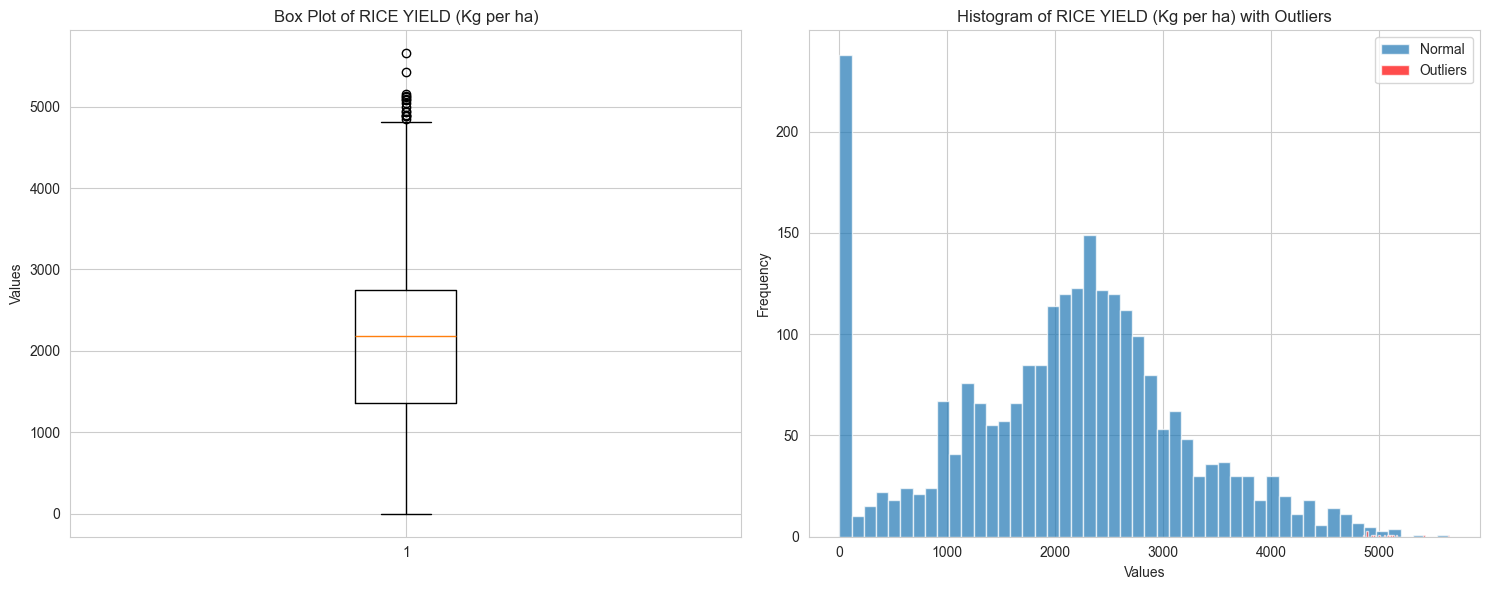


WHEAT YIELD (Kg per ha):
  Lower bound: -1691.22, Upper bound: 6018.69
  Number of outliers: 0
  Outlier percentage: 0.00%

SUGARCANE YIELD (Kg per ha):
  Lower bound: -8368.19, Upper bound: 16762.43
  Number of outliers: 5
  Outlier percentage: 0.20%


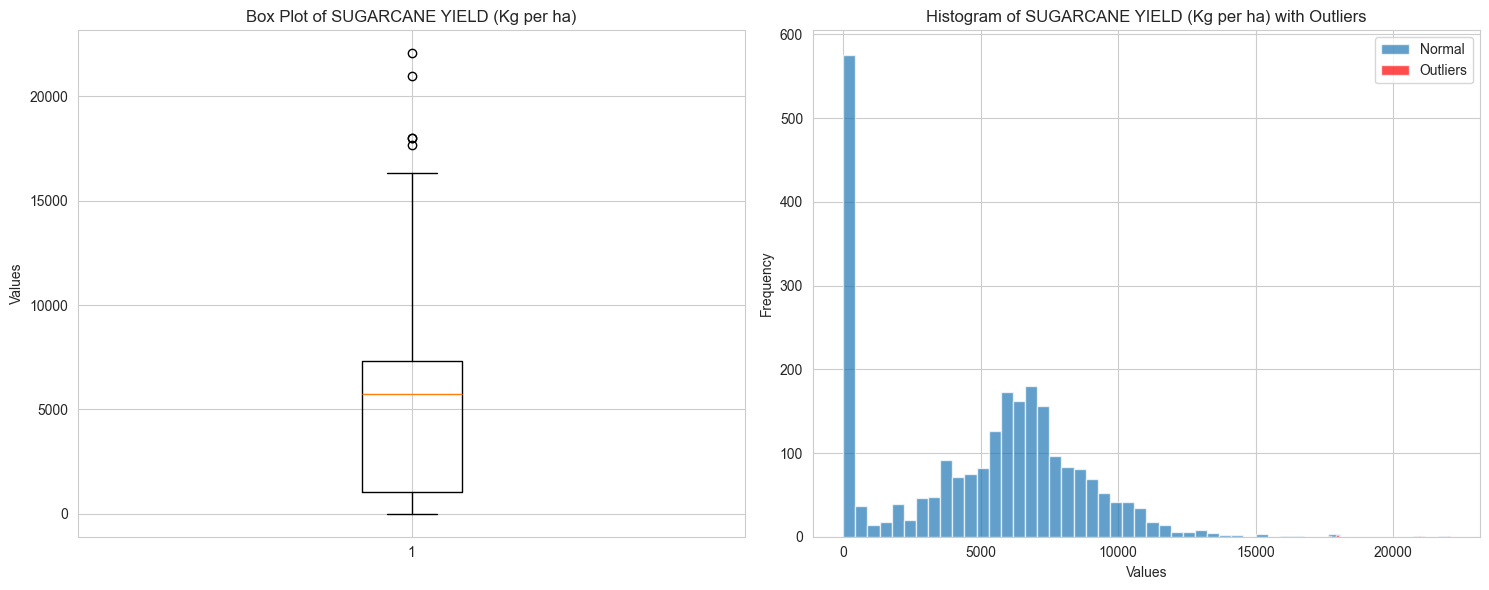


COTTON YIELD (Kg per ha):
  Lower bound: -503.79, Upper bound: 839.65
  Number of outliers: 41
  Outlier percentage: 1.65%


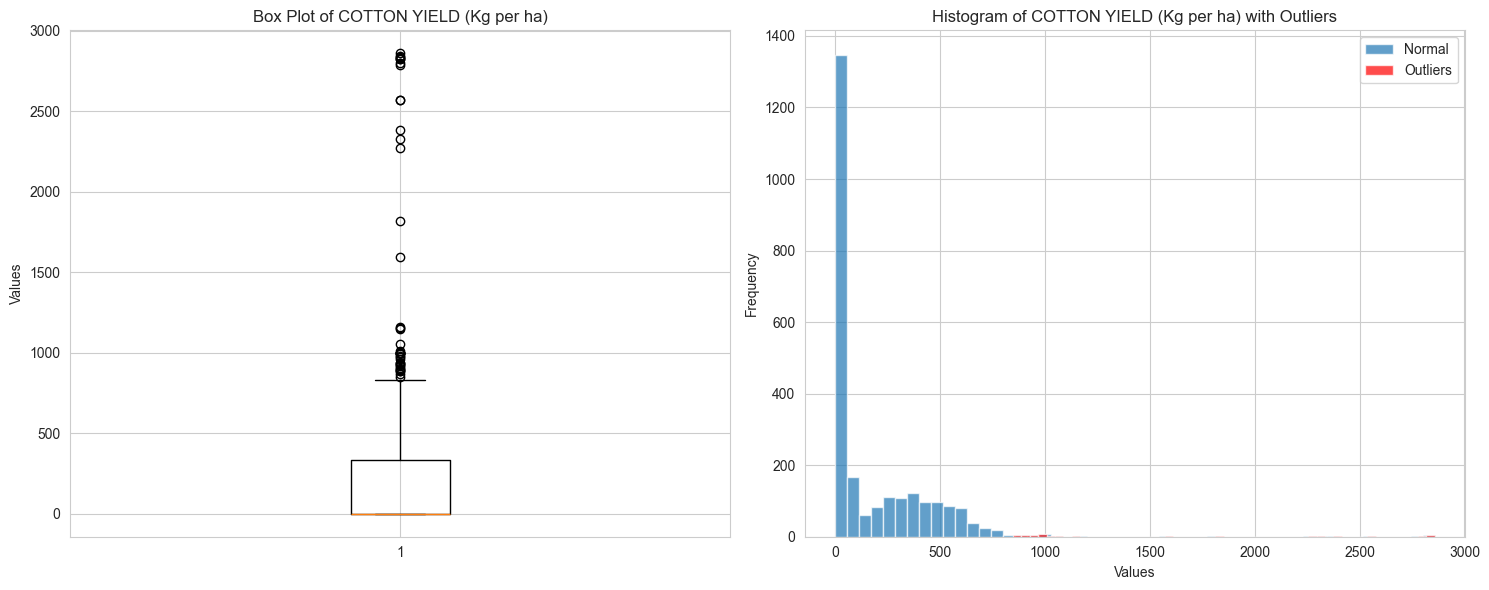

In [44]:
# 6. Outlier Detection and Treatment

def detect_outliers_iqr(df, column):
    """Detect outliers using IQR method """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR  = Q3 -Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers,lower_bound ,upper_bound


def visualize_outliers(df,column):
    """Vizualize outliers for a specific column"""
    fig , axes = plt.subplots(1,2, figsize =(15,6))


    # Box plot 

    axes[0].boxplot(df[column].dropna())
    axes[0].set_title(f"Box Plot of {column}")
    axes[0].set_ylabel('Values')



    #Histogram with outliers highlighted 


    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[column] < Q1 - 1.5*IQR) | (df[column] > Q3 + 1.5*IQR)][column]
    
    axes[1].hist(df[column].dropna(), bins=50, alpha=0.7, label='Normal')
    axes[1].hist(outliers, bins=50, alpha=0.7, color='red', label='Outliers')
    axes[1].set_title(f'Histogram of {column} with Outliers')
    axes[1].set_xlabel('Values')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


# Check key columns for outliers
key_columns = ['RICE YIELD (Kg per ha)', 'WHEAT YIELD (Kg per ha)', 
               'SUGARCANE YIELD (Kg per ha)', 'COTTON YIELD (Kg per ha)']

for col in key_columns:
    if col in df_clean.columns:
        outliers, lower, upper = detect_outliers_iqr(df_clean, col)
        print(f"\n{col}:")
        print(f"  Lower bound: {lower:.2f}, Upper bound: {upper:.2f}")
        print(f"  Number of outliers: {len(outliers)}")
        print(f"  Outlier percentage: {len(outliers)/len(df_clean)*100:.2f}%")
        
        if len(outliers) > 0:
            visualize_outliers(df_clean, col)


def handle_outliers(df, method='winsorize'):
    """Handle outliers using specified method"""
    
    df_processed = df.copy()
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    
    # Remove ID columns from outlier treatment
    id_cols = ['Dist Code', 'State Code', 'Year']
    numerical_cols = [col for col in numerical_cols if col not in id_cols]
    
    if method == 'winsorize':
        # Winsorize outliers (cap at 1st and 99th percentiles)
        for col in numerical_cols:
            lower_limit = df_processed[col].quantile(0.01)
            upper_limit = df_processed[col].quantile(0.99)
            df_processed[col] = df_processed[col].clip(lower=lower_limit, upper=upper_limit)
    
    elif method == 'iqr':
        # Cap outliers using IQR method
        for col in numerical_cols:
            Q1 = df_processed[col].quantile(0.25)
            Q3 = df_processed[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            df_processed[col] = df_processed[col].clip(lower=lower_bound, upper=upper_bound)
    
    return df_processed

    # Apply outlier handling
df_clean = handle_outliers(df_clean, method='winsorize')


      

In [45]:
# 7. Feature Engineering :




def create_derived_features(df):
    """Create meaningful derived features"""
    
    df_enhanced = df.copy()
    
    # 1. Calculate total agricultural area
    area_columns = [col for col in df.columns if 'AREA' in col and '1000 ha' in col]
    df_enhanced['TOTAL_AREA_1000_ha'] = df_enhanced[area_columns].sum(axis=1, min_count=1)
    
    # 2. Calculate total production
    production_columns = [col for col in df.columns if 'PRODUCTION' in col and '1000 tons' in col]
    df_enhanced['TOTAL_PRODUCTION_1000_tons'] = df_enhanced[production_columns].sum(axis=1, min_count=1)
    
    # 3. Calculate overall yield (weighted average)
    df_enhanced['OVERALL_YIELD_Kg_per_ha'] = df_enhanced['TOTAL_PRODUCTION_1000_tons'] * 1000 / df_enhanced['TOTAL_AREA_1000_ha']
    
    # 4. Calculate crop diversification index (Herfindahl-Hirschman Index)
    area_proportion_columns = []
    for area_col in area_columns:
        prop_col = f'{area_col}_PROPORTION'
        df_enhanced[prop_col] = df_enhanced[area_col] / df_enhanced['TOTAL_AREA_1000_ha']
        area_proportion_columns.append(prop_col)
    
    df_enhanced['CROP_DIVERSIFICATION_INDEX'] = (df_enhanced[area_proportion_columns] ** 2).sum(axis=1)
    
    # 5. Create productivity efficiency metrics
    df_enhanced['PRODUCTIVITY_EFFICIENCY'] = df_enhanced['OVERALL_YIELD_Kg_per_ha'] / df_enhanced['OVERALL_YIELD_Kg_per_ha'].max()
    
    # 6. Create year-based features
    df_enhanced['YEAR_SINCE_2010'] = df_enhanced['Year'] - 2010
    df_enhanced['IS_MONSOON_YEAR'] = ((df_enhanced['Year'] % 4) == 0).astype(int)  # Simple proxy
    
    # 7. Calculate year-over-year growth rates
    df_enhanced = df_enhanced.sort_values(['State Name', 'Dist Name', 'Year'])
    
    for col in ['TOTAL_PRODUCTION_1000_tons', 'OVERALL_YIELD_Kg_per_ha']:
        df_enhanced[f'{col}_YoY_Growth'] = df_enhanced.groupby(['State Name', 'Dist Name'])[col].pct_change()
    
    return df_enhanced

df_enhanced = create_derived_features(df_clean)


# Display new features
print("New Derived Features Created:")
new_features = [col for col in df_enhanced.columns if col not in df.columns]
for feature in new_features:
    print(f"  - {feature}")



New Derived Features Created:
  - TOTAL_AREA_1000_ha
  - TOTAL_PRODUCTION_1000_tons
  - OVERALL_YIELD_Kg_per_ha
  - RICE AREA (1000 ha)_PROPORTION
  - WHEAT AREA (1000 ha)_PROPORTION
  - KHARIF SORGHUM AREA (1000 ha)_PROPORTION
  - RABI SORGHUM AREA (1000 ha)_PROPORTION
  - SORGHUM AREA (1000 ha)_PROPORTION
  - PEARL MILLET AREA (1000 ha)_PROPORTION
  - MAIZE AREA (1000 ha)_PROPORTION
  - FINGER MILLET AREA (1000 ha)_PROPORTION
  - BARLEY AREA (1000 ha)_PROPORTION
  - CHICKPEA AREA (1000 ha)_PROPORTION
  - PIGEONPEA AREA (1000 ha)_PROPORTION
  - MINOR PULSES AREA (1000 ha)_PROPORTION
  - GROUNDNUT AREA (1000 ha)_PROPORTION
  - SESAMUM AREA (1000 ha)_PROPORTION
  - RAPESEED AND MUSTARD AREA (1000 ha)_PROPORTION
  - SAFFLOWER AREA (1000 ha)_PROPORTION
  - CASTOR AREA (1000 ha)_PROPORTION
  - LINSEED AREA (1000 ha)_PROPORTION
  - SUNFLOWER AREA (1000 ha)_PROPORTION
  - SOYABEAN AREA (1000 ha)_PROPORTION
  - OILSEEDS AREA (1000 ha)_PROPORTION
  - SUGARCANE AREA (1000 ha)_PROPORTION
  - COT

In [46]:
# 8. Data validation and Quality Checks 


def perform_data_validation(df):
    """Perform comprehensive data validation"""
    
    validation_results = {}
    
    # 1. Check for logical consistency
    validation_results['yield_consistency'] = {}
    yield_columns = [col for col in df.columns if 'YIELD' in col]
    
    for col in yield_columns:
        # Yield should be positive
        negative_yields = df[df[col] < 0]
        validation_results['yield_consistency'][col] = {
            'negative_count': len(negative_yields),
            'percentage': len(negative_yields) / len(df) * 100
        }
    
    # 2. Check area-production-yield relationship
    validation_results['area_prod_yield'] = {}
    crops = ['RICE', 'WHEAT', 'SUGARCANE']
    
    for crop in crops:
        area_col = f'{crop} AREA (1000 ha)'
        prod_col = f'{crop} PRODUCTION (1000 tons)'
        yield_col = f'{crop} YIELD (Kg per ha)'
        
        if all(col in df.columns for col in [area_col, prod_col, yield_col]):
            # Calculate expected yield
            expected_yield = (df[prod_col] * 1000) / df[area_col]
            
            # Check consistency (allow 10% tolerance)
            tolerance = 0.1
            inconsistent = df[abs(expected_yield - df[yield_col]) / df[yield_col] > tolerance]
            
            validation_results['area_prod_yield'][crop] = {
                'inconsistent_count': len(inconsistent),
                'percentage': len(inconsistent) / len(df) * 100
            }
    
    return validation_results

# Run validation
validation_results = perform_data_validation(df_enhanced)
print("Data Validation Results:")
print("=" * 80)
for check_type, results in validation_results.items():
    print(f"\n{check_type.upper()}:")
    for key, value in results.items():
        print(f"  {key}: {value}")


Data Validation Results:

YIELD_CONSISTENCY:
  RICE YIELD (Kg per ha): {'negative_count': 0, 'percentage': 0.0}
  WHEAT YIELD (Kg per ha): {'negative_count': 0, 'percentage': 0.0}
  KHARIF SORGHUM YIELD (Kg per ha): {'negative_count': 0, 'percentage': 0.0}
  RABI SORGHUM YIELD (Kg per ha): {'negative_count': 0, 'percentage': 0.0}
  SORGHUM YIELD (Kg per ha): {'negative_count': 0, 'percentage': 0.0}
  PEARL MILLET YIELD (Kg per ha): {'negative_count': 0, 'percentage': 0.0}
  MAIZE YIELD (Kg per ha): {'negative_count': 0, 'percentage': 0.0}
  FINGER MILLET YIELD (Kg per ha): {'negative_count': 0, 'percentage': 0.0}
  BARLEY YIELD (Kg per ha): {'negative_count': 0, 'percentage': 0.0}
  CHICKPEA YIELD (Kg per ha): {'negative_count': 0, 'percentage': 0.0}
  PIGEONPEA YIELD (Kg per ha): {'negative_count': 0, 'percentage': 0.0}
  MINOR PULSES YIELD (Kg per ha): {'negative_count': 0, 'percentage': 0.0}
  GROUNDNUT YIELD (Kg per ha): {'negative_count': 0, 'percentage': 0.0}
  SESAMUM YIELD (Kg 

In [49]:
# 9. Save Cleaned Dataset 

 

# Save CSV normally
df_enhanced.to_csv('cleaned_agricultural_data.csv', index=False)

# Save Parquet using fastparquet instead of pyarrow
df_enhanced.to_parquet(
    'cleaned_agricultural_data.parquet',
    index=False,
    engine='fastparquet'
)

# Save metadata
metadata = {
    'cleaning_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'original_shape': df.shape,
    'cleaned_shape': df_enhanced.shape,
    'missing_values_original': df.isnull().sum().sum(),
    'missing_values_cleaned': df_enhanced.isnull().sum().sum(),
    'new_features_created': len([col for col in df_enhanced.columns if col not in df.columns]),
    'validation_results': validation_results
}

with open('data_cleaning_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("=" * 80)
print("DATA CLEANING COMPLETE")
print("=" * 80)
print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_enhanced.shape}")
print("Files saved:")
print("  - cleaned_agricultural_data.csv")
print("  - cleaned_agricultural_data.parquet (fastparquet engine)")
print("  - data_cleaning_metadata.pkl")
print(f"\nCleaning completed at: {datetime.now()}")


DATA CLEANING COMPLETE
Original dataset shape: (2484, 80)
Cleaned dataset shape: (2484, 118)
Files saved:
  - cleaned_agricultural_data.csv
  - cleaned_agricultural_data.parquet (fastparquet engine)
  - data_cleaning_metadata.pkl

Cleaning completed at: 2025-12-02 16:56:13.947289
